In [79]:
!pip install beautifulsoup4 networkx requests

Starting crawl from https://en.wikipedia.org/wiki/Information_technology
Crawling page 1: https://en.wikipedia.org/wiki/Information_technology
Crawling page 2: https://en.wikipedia.org/wiki/Information_Technology_(constituency)
Crawling page 3: https://en.wikipedia.org/wiki/Nonpartisan_politician
Crawling page 4: https://en.wikipedia.org/wiki/2016_United_States_presidential_election
Crawling page 5: https://en.wikipedia.org/wiki/Mixed-member_proportional_representation
Crawling page 6: https://en.wikipedia.org/wiki/File:Castle_Bradley_banner.jpg
Crawling page 7: https://en.wikipedia.org/wiki/Marshal_of_Finland
Crawling page 8: https://en.wikipedia.org/wiki/Flexible_electronics
Crawling page 9: https://en.wikipedia.org/wiki/Electronic_computers
Crawling page 10: https://en.wikipedia.org/wiki/Palmer_United_Party
Crawling page 11: https://en.wikipedia.org/wiki/Democratic-Republican_Party
Crawling page 12: https://en.wikipedia.org/wiki/Nebraska%27s_2nd_congressional_district
Crawling page 

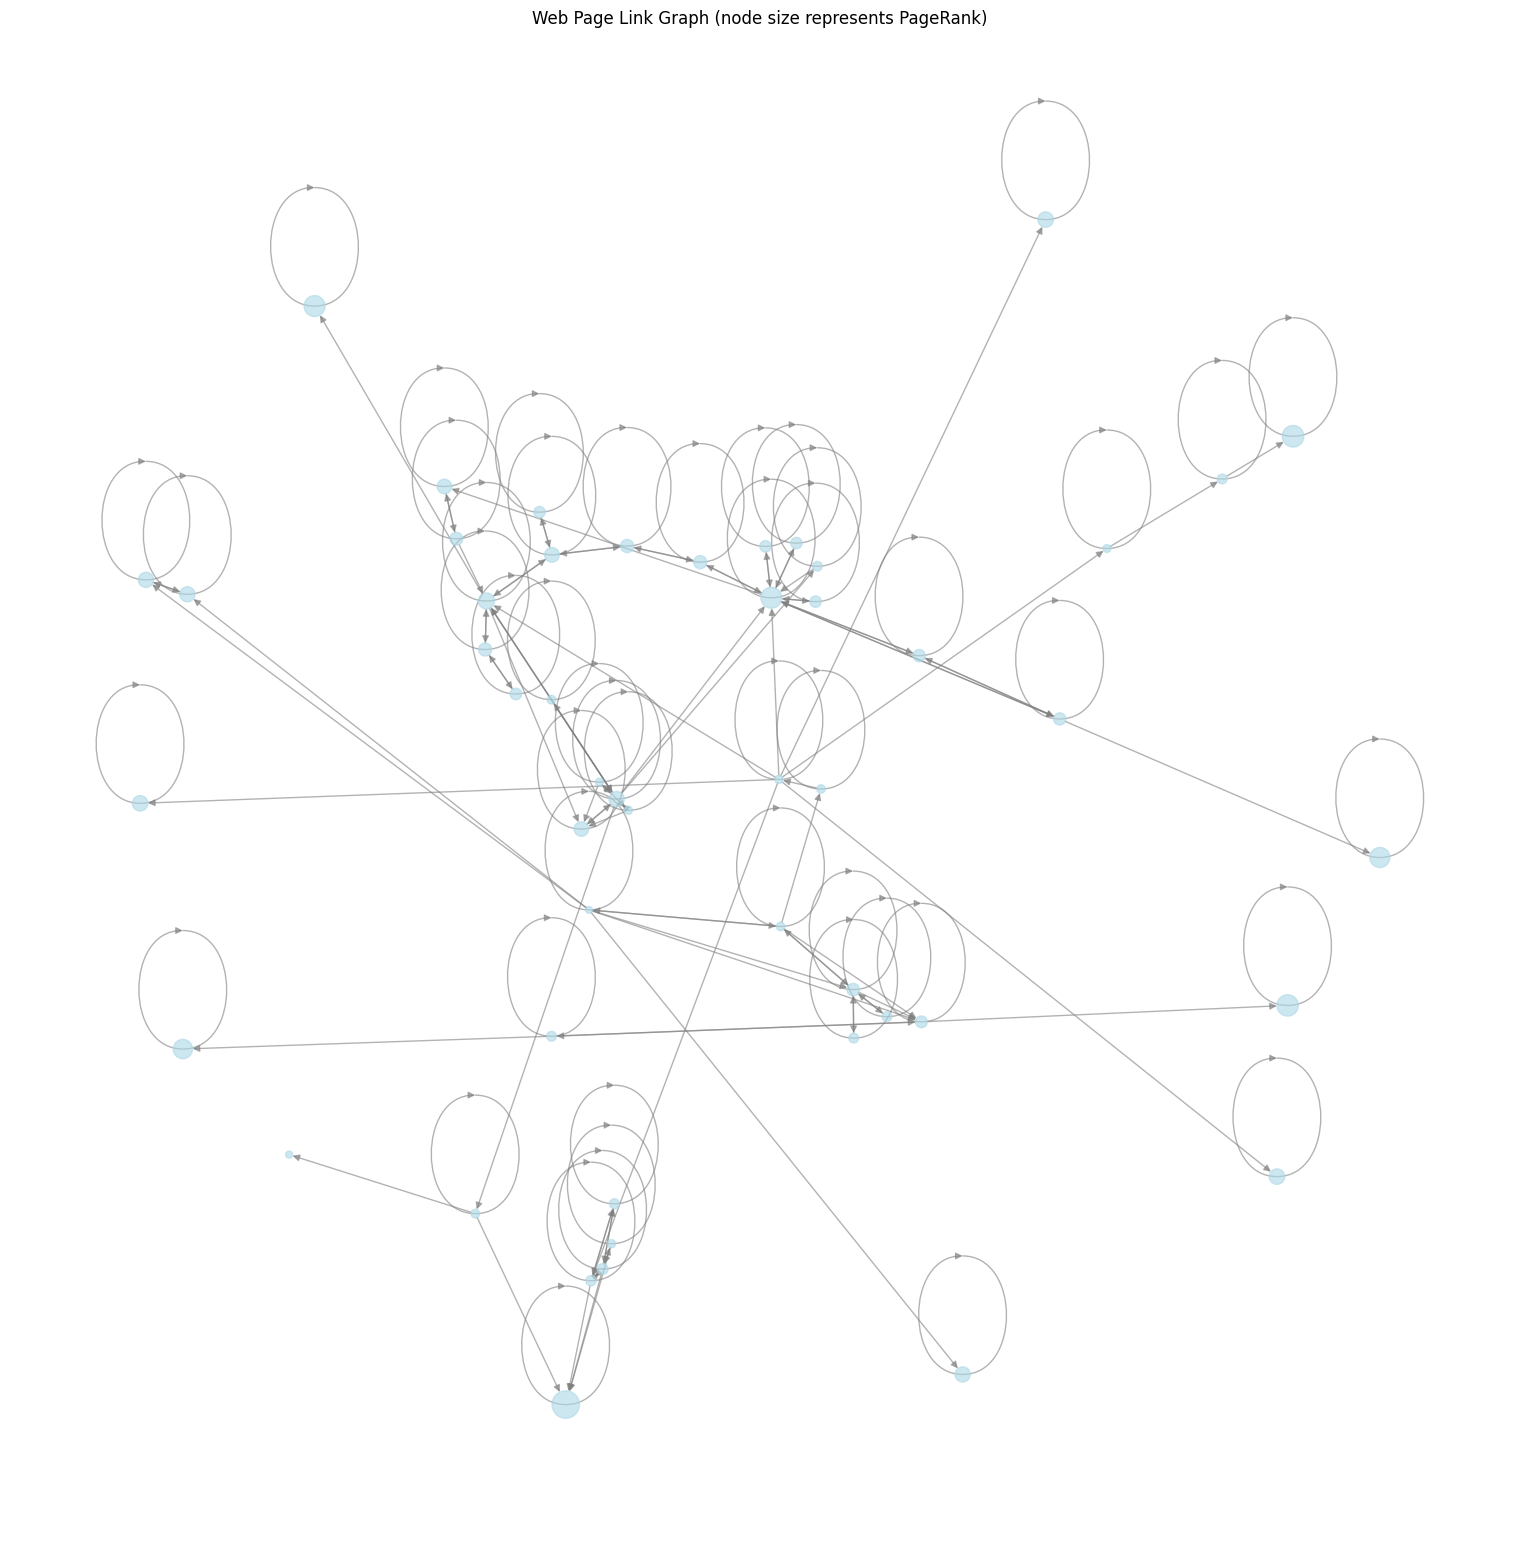

In [83]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.parse import urljoin, urlparse
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import time
from typing import List, Set, Dict
import warnings
warnings.filterwarnings('ignore')

class WebCrawler:
    def __init__(self, start_url: str, max_pages: int = 100, allowed_domain: str = None):
        """
        Initialize the web crawler

        Args:
            start_url (str): The starting URL for crawling
            max_pages (int): Maximum number of pages to crawl
            allowed_domain (str): Domain to restrict crawling to
        """
        self.start_url = start_url
        self.max_pages = max_pages
        self.allowed_domain = allowed_domain or urlparse(start_url).netloc
        self.visited_pages: Set[str] = set()
        self.pages_to_visit: Set[str] = {start_url}
        self.link_graph: Dict[str, Set[str]] = defaultdict(set)

    def is_valid_url(self, url: str) -> bool:
        """Check if URL is valid and within allowed domain"""
        try:
            parsed = urlparse(url)
            return (
                bool(parsed.netloc) and
                bool(parsed.scheme) and
                parsed.netloc == self.allowed_domain and
                '#' not in url
            )
        except:
            return False

    def get_links_from_page(self, url: str) -> Set[str]:
        """Extract all valid links from a web page"""
        try:
            response = requests.get(url, timeout=5)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')

            links = set()
            for anchor in soup.find_all('a'):
                href = anchor.get('href')
                if href:
                    absolute_url = urljoin(url, href)
                    if self.is_valid_url(absolute_url):
                        links.add(absolute_url)
            return links

        except Exception as e:
            print(f"Error crawling {url}: {str(e)}")
            return set()

    def crawl(self) -> Dict[str, Set[str]]:
        """
        Crawl web pages starting from start_url and build link graph

        Returns:
            Dict[str, Set[str]]: Graph of page links
        """
        print(f"Starting crawl from {self.start_url}")

        while self.pages_to_visit and len(self.visited_pages) < self.max_pages:
            current_url = self.pages_to_visit.pop()

            if current_url in self.visited_pages:
                continue

            print(f"Crawling page {len(self.visited_pages) + 1}: {current_url}")

            # Get links from current page
            page_links = self.get_links_from_page(current_url)
            self.link_graph[current_url].update(page_links)

            # Add new links to pages_to_visit
            self.pages_to_visit.update(
                link for link in page_links
                if link not in self.visited_pages
            )

            self.visited_pages.add(current_url)
            time.sleep(1)  # Be nice to servers

        return self.link_graph

class PageRanker:
    def __init__(self, damping_factor: float = 0.85, epsilon: float = 1e-8):
        """
        Initialize PageRank calculator

        Args:
            damping_factor (float): Damping factor for PageRank
            epsilon (float): Convergence threshold
        """
        self.damping_factor = damping_factor
        self.epsilon = epsilon

    def build_adjacency_matrix(self, link_graph: Dict[str, Set[str]]) -> tuple:
        """Convert link graph to adjacency matrix"""
        # Create mapping of urls to indices
        urls = list(link_graph.keys())
        url_to_index = {url: i for i, url in enumerate(urls)}

        n = len(urls)
        matrix = np.zeros((n, n))

        for source, targets in link_graph.items():
            source_idx = url_to_index[source]

            # Get valid target indices
            target_indices = [
                url_to_index[target]
                for target in targets
                if target in url_to_index
            ]

            if target_indices:
                # Distribute probability equally among outbound links
                matrix[target_indices, source_idx] = 1.0 / len(target_indices)

        return matrix, urls

    def calculate_pagerank(self, link_graph: Dict[str, Set[str]]) -> pd.DataFrame:
        """
        Calculate PageRank scores for pages in link graph

        Args:
            link_graph (Dict[str, Set[str]]): Graph of page links

        Returns:
            pd.DataFrame: DataFrame with URLs and PageRank scores
        """
        # Build adjacency matrix
        matrix, urls = self.build_adjacency_matrix(link_graph)
        n = len(urls)

        # Initialize PageRank scores
        pagerank = np.ones(n) / n

        # Power iteration method
        while True:
            prev_pagerank = pagerank.copy()

            # Calculate new PageRank values
            pagerank = (1 - self.damping_factor) / n + \
                      self.damping_factor * matrix.dot(prev_pagerank)

            # Check convergence
            if np.sum(np.abs(pagerank - prev_pagerank)) < self.epsilon:
                break

        # Create results DataFrame
        results = pd.DataFrame({
            'url': urls,
            'pagerank': pagerank
        })
        return results.sort_values('pagerank', ascending=False)

    def visualize_graph(self, link_graph: Dict[str, Set[str]], pageranks: pd.DataFrame):
        """Create visualization of page link graph"""
        G = nx.DiGraph()

        # Add nodes and edges
        for source, targets in link_graph.items():
            for target in targets:
                if target in pageranks['url'].values:
                    G.add_edge(source, target)

        # Set node sizes based on PageRank
        pagerank_dict = pageranks.set_index('url')['pagerank'].to_dict()
        node_sizes = [pagerank_dict[url] * 5000 for url in G.nodes()]

        # Create layout and plot
        plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(G)
        nx.draw(G, pos,
                node_size=node_sizes,
                node_color='lightblue',
                with_labels=False,
                arrows=True,
                edge_color='gray',
                alpha=0.6)
        plt.title("Web Page Link Graph (node size represents PageRank)")
        plt.show()

def main():
    # Example usage
    start_url = "https://en.wikipedia.org/wiki/Information_technology"  # Replace with actual URL

    # Create crawler and build link graph
    crawler = WebCrawler(start_url, max_pages=50)
    link_graph = crawler.crawl()

    print("\nCrawling completed. Processing results...")

    # Calculate PageRank
    ranker = PageRanker()
    pageranks = ranker.calculate_pagerank(link_graph)

    # Display results
    print("\nTop 10 Pages by PageRank:")
    print(pageranks.head(10))

    # Visualize the graph
    print("\nGenerating visualization...")
    ranker.visualize_graph(link_graph, pageranks)

if __name__ == "__main__":
    main()